In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import pandas as pd

## Getting IMDB Cast
https://imdb-api.com/en/API/FullCast/{api_key}/{id}

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IMDBdata/IMDB_infos.csv')[['IMDBid', 'index']]

In [ ]:
cvktoimdb = df.set_index('index').to_dict()
imdbtocvk = df.set_index('IMDBid').to_dict()

## Doing NER Tagging

In [ ]:
!pip install spacytextblob
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords
import re

In [ ]:
from nltk import tokenize

In [ ]:
import glob
comment_paths = glob.glob('/content/drive/MyDrive/IMDB/reviews_rat/*')
print(len(comment_paths))

617


In [ ]:
all_data = []
for path in comment_paths:
  data = pd.read_csv(path)
  imdb = path.split('/')[-1].split('.')[0]
  data['imdb_id'] = imdb
  data['cnvk_id'] = imdbtocvk['index'][imdb]
  all_data.append(data)
data = pd.concat(all_data)
data.shape

(316132, 8)

In [ ]:
data=data.reset_index(drop=True)

In [ ]:
import json

In [ ]:
with open('/content/drive/MyDrive/IMDBdata/characters.json') as f:
  all_characters = json.load(f)

In [ ]:
female_characters = {}
male_characters = {}
for movie in all_characters:
  for charac in all_characters[movie]:
    if all_characters[movie][charac]['gender'] == 'f':
      try:
        female_characters[movie][charac] = all_characters[movie][charac]
      except:
        female_characters[movie] = {}
        female_characters[movie][charac] = all_characters[movie][charac]
    elif all_characters[movie][charac]['gender'] == 'm':
      try:
        male_characters[movie][charac] = all_characters[movie][charac]
      except:
        male_characters[movie] = {}
        male_characters[movie][charac] = all_characters[movie][charac]

## Pre-loading Models for Sentiment Analysis


### With some pronouns and verb-filtered

In [ ]:
male_pronouns = ['he', 'him', 'man', 'men', 'boy']
female_pronouns = ['she', 'her', 'woman', 'women', 'girl']
pronouns = male_pronouns + female_pronouns
filter_verbs = ['direct', 'film', 'role-play', 'act', 'perform', 'portray', 'cast']

### Textblob for sentiment analysis

In [ ]:
from textblob import TextBlob

### Self-trained Sentiment Analysis Model

In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
import transformers
from tqdm import tqdm, trange
import pandas as pd
import io

In [ ]:
model = torch.load('/content/drive/MyDrive/IMDBdata/self-trained-sa')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
pred = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, truncation=True, return_all_scores=True)

# Run through all movies

In [ ]:
def get_character_part(reviews, movie):
  # character_related_sents = []
  character_related_reviews = []
  for review in reviews:
    locations = []
    isCharact = []
    cnt = 0
    review_level = []
    sentences = tokenize.sent_tokenize(review)
    for sent in sentences:
      sent = nlp(sent)
      person = False
      isChara = False
      for ent in sent.ents:
        if ent.label_ == "PERSON":
          person = True
          for charac in all_characters[movie].keys():
            if charac in ent.text.upper():
              isChara = True
      if person:
        locations.append(cnt)
        isCharact.append(isChara)
      else:
        try:
          if isCharact[-1]:
            add_this = False
            for pronoun in pronouns:
              if pronoun in sent.text.lower().split():
                add_this = True
            if add_this:
              isCharact.append(True)
            else:
              isCharact.append(False)
            locations.append(cnt)
          else:
            locations.append(cnt)
            isCharact.append(False)
        except:
          locations.append(cnt)
          isCharact.append(False)
      cnt += 1
    for i in range(len(sentences)):
      if isCharact[i]:
        # character_related_sents.append(sentences[i])
        review_level.append(sentences[i])
    character_related_reviews.append(review_level)
  return character_related_reviews

In [ ]:
def separate_gender(reviews):
  male_reviews = []
  female_reviews = []
  for character_related in reviews:
    male_character_related = []
    female_character_related = []
    for sent in character_related:
      add_in_male = False
      for pronoun in male_pronouns:
        if pronoun in sent.lower().split():
          male_character_related.append(sent)
          add_in_male = True
          break
      if not add_in_male:
        for charac in male_characters['m594']:
          if charac in sent.upper():
            male_character_related.append(sent)
            break
      add_in_female = False
      for pronoun in female_pronouns:
        if pronoun in sent.lower().split():
          female_character_related.append(sent)
          add_in_female = True
          break
      if not add_in_female:
        for charac in female_characters['m594']:
          if charac in sent.upper():
            female_character_related.append(sent)
            break
    if len(male_character_related) > 0:
      male_reviews.append(male_character_related)
    if len(female_character_related) > 0:
      female_reviews.append(female_character_related)
  return male_reviews, female_reviews

In [ ]:
def get_sentence_level_sentiments(reviews, pred):
  reviews = [item for sublist in reviews for item in sublist]
  polarity_blob = []
  subjectivity_blob = []
  for sent in reviews:
    sentiments = TextBlob(sent).sentiment
    polarity_blob.append(sentiments[0])
    subjectivity_blob.append(sentiments[1])
  results = pred(reviews)
  self_sentiment = [result[1]['score'] for result in results]
  return polarity_blob, subjectivity_blob, self_sentiment

In [ ]:
def get_review_level_sentiments(reviews, pred):
  reviews = [' '.join(sublist) for sublist in reviews]
  polarity_blob = []
  subjectivity_blob = []
  for sent in reviews:
    sentiments = TextBlob(sent).sentiment
    polarity_blob.append(sentiments[0])
    subjectivity_blob.append(sentiments[1])
  results = pred(reviews)
  self_sentiment = [result[1]['score'] for result in results]
  return polarity_blob, subjectivity_blob, self_sentiment

## Edited Version

In [ ]:
cnt = 0
results_dict = {}
for movie in data.imdb_id.unique():
  try:
    results_dict[movie] = {}
    reviews = data[data['imdb_id'] == movie]
    reviews = get_character_part(reviews.review, data[data['imdb_id'] == movie].cnvk_id.values[0])
    male_part, female_part = separate_gender(reviews)
    # male_polarity_blob, male_subjectivity_blob, male_self_sentiment = get_sentence_level_sentiments(male_part, pred)
    # female_polarity_blob, female_subjectivity_blob, female_self_sentiment = get_sentence_level_sentiments(female_part, pred)
    # results_dict[movie]['male_sent_blob'] = male_polarity_blob
    # results_dict[movie]['male_sent_subj'] = male_subjectivity_blob
    # results_dict[movie]['male_sent_self'] = male_self_sentiment
    # results_dict[movie]['female_sent_blob'] = female_polarity_blob
    # results_dict[movie]['female_sent_subj'] = female_subjectivity_blob
    # results_dict[movie]['female_sent_self'] = female_self_sentiment
    male_polarity_blob, male_subjectivity_blob, male_self_sentiment = get_review_level_sentiments(male_part, pred)
    female_polarity_blob, female_subjectivity_blob, female_self_sentiment = get_review_level_sentiments(female_part, pred)
    results_dict[movie]['male_revw_blob'] = male_polarity_blob
    results_dict[movie]['male_revw_subj'] = male_subjectivity_blob
    results_dict[movie]['male_revw_self'] = male_self_sentiment
    results_dict[movie]['female_revw_blob'] = female_polarity_blob
    results_dict[movie]['female_revw_subj'] = female_subjectivity_blob
    results_dict[movie]['female_revw_self'] = female_self_sentiment
    with open(f'/content/drive/MyDrive/IMDB/sentiments/{movie}.json', 'w') as f:
      json.dump(results_dict[movie], f)
  except:
    print(movie)
  print(cnt, end=' ')
  cnt += 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

# Run through all movies (Adding Time Label)

In [ ]:
len(data.imdb_id.unique())

584

## Edited Version

In [ ]:
data.head(5)

,title,user,rating,date,spoil,review,imdb_id,cnvk_id
0,One of the year's best films; brilliantly acte...,ur0111563,9.0,2000-12-27,0,AFFLICTION / (1997) **** (out of four) By Blak...,tt0118564,m10
1,A disturbing examination of the fruits of abus...,ur3314616,8.0,2005-10-12,1,I have watched this movie several times and re...,tt0118564,m10
2,Affliction Clearly Schrader's Best Film To Date,ur2567338,9.0,2009-11-25,1,Roger Ebert described it well. The effects of ...,tt0118564,m10
3,"a masterpiece, true art",ur0007627,9.0,1999-02-06,0,This is a movie which rewards at many levels. ...,tt0118564,m10
4,"Deep, complex, depressing",ur1903880,NaN,2004-04-17,0,"""Affliction"" doesn't have an immediate plot. ...",tt0118564,m10


In [ ]:
data['review_year'] = data['date'].apply(lambda x: x.split('-')[0])
data.head(5)

,title,user,rating,date,spoil,review,imdb_id,cnvk_id,review_year
0,One of the year's best films; brilliantly acte...,ur0111563,9.0,2000-12-27,0,AFFLICTION / (1997) **** (out of four) By Blak...,tt0118564,m10,2000
1,A disturbing examination of the fruits of abus...,ur3314616,8.0,2005-10-12,1,I have watched this movie several times and re...,tt0118564,m10,2005
2,Affliction Clearly Schrader's Best Film To Date,ur2567338,9.0,2009-11-25,1,Roger Ebert described it well. The effects of ...,tt0118564,m10,2009
3,"a masterpiece, true art",ur0007627,9.0,1999-02-06,0,This is a movie which rewards at many levels. ...,tt0118564,m10,1999
4,"Deep, complex, depressing",ur1903880,NaN,2004-04-17,0,"""Affliction"" doesn't have an immediate plot. ...",tt0118564,m10,2004


In [ ]:
import matplotlib.pyplot as plt

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 <a list of 25 Text major ticklabel objects>)

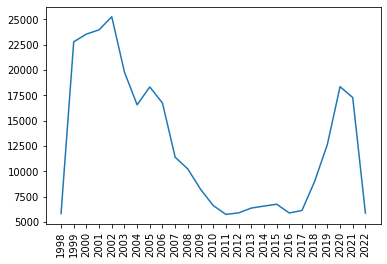

In [ ]:
plt.plot(sorted(dict(data.review_year.value_counts())), [data.review_year.value_counts()[year] for year in sorted(dict(data.review_year.value_counts()))])
plt.xticks(rotation=90)

In [39]:
data.review_year.unique()[1:]

array(['2005', '2009', '1999', '2004', '2007', '2002', '2008', '2015',
       '2003', '2012', '2021', '2010', '2019', '2001', '2006', '2017',
       '2013', '2022', '2016', '2018', '2020', '1998', '2014', '2011'],
      dtype=object)

In [40]:
for year in data.review_year.unique()[1:]:
  results_dict = {}
  tmp_data = data[data['review_year']==year]
  for movie in tmp_data.imdb_id.unique():
    try:
      results_dict[movie] = {}
      reviews = tmp_data[tmp_data['imdb_id'] == movie]
      reviews = get_character_part(reviews.review, tmp_data[tmp_data['imdb_id'] == movie].cnvk_id.values[0])
      male_part, female_part = separate_gender(reviews)
      # male_polarity_blob, male_subjectivity_blob, male_self_sentiment = get_sentence_level_sentiments(male_part, pred)
      # female_polarity_blob, female_subjectivity_blob, female_self_sentiment = get_sentence_level_sentiments(female_part, pred)
      # results_dict[movie]['male_sent_blob'] = male_polarity_blob
      # results_dict[movie]['male_sent_subj'] = male_subjectivity_blob
      # results_dict[movie]['male_sent_self'] = male_self_sentiment
      # results_dict[movie]['female_sent_blob'] = female_polarity_blob
      # results_dict[movie]['female_sent_subj'] = female_subjectivity_blob
      # results_dict[movie]['female_sent_self'] = female_self_sentiment
      male_polarity_blob, male_subjectivity_blob, male_self_sentiment = get_review_level_sentiments(male_part, pred)
      female_polarity_blob, female_subjectivity_blob, female_self_sentiment = get_review_level_sentiments(female_part, pred)
      results_dict[movie]['male_revw_blob'] = male_polarity_blob
      results_dict[movie]['male_revw_subj'] = male_subjectivity_blob
      results_dict[movie]['male_revw_self'] = male_self_sentiment
      results_dict[movie]['female_revw_blob'] = female_polarity_blob
      results_dict[movie]['female_revw_subj'] = female_subjectivity_blob
      results_dict[movie]['female_revw_self'] = female_self_sentiment
    except:
      print(year, movie)
  with open(f'/content/drive/MyDrive/IMDB/sentiment_year/{year}.json', 'w') as f:
        json.dump(results_dict, f)
  print(year, end=' ')

2005 2009 1999 2004 2007 2002 2008 2015 2003 2012 2021 2010 2019 2001 2006 2017 2013 2022 2016 2018 2020 1998 2014 2011 